In [1]:
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

//anaconda/envs/opencv_27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


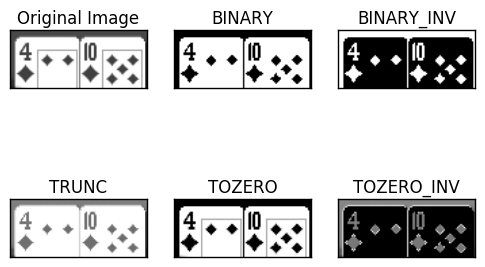

In [89]:
# Pixel value: 0 is black, 255 is white

img = cv2.imread('training/4Tdd.png' ,0)
ret,thresh1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,150,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,150,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,150,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

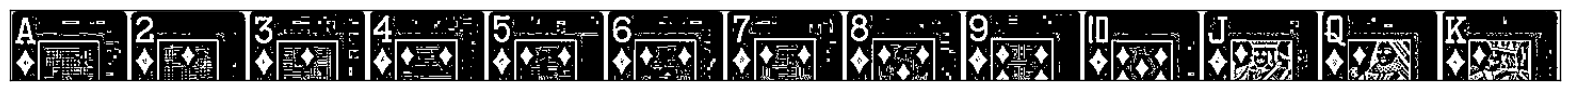

In [92]:
img = cv2.imread('training/train1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(1,1),1000)
thresh1 = cv2.adaptiveThreshold(blur,255,1,1,11,1)
# ret,thresh1 = cv2.threshold(blur,150,255,cv2.THRESH_BINARY)
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(thresh1,'gray')
plt.title("")
plt.xticks([]),plt.yticks([])
plt.show()

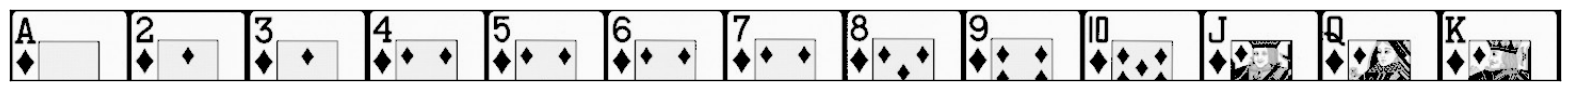

In [94]:
img = cv2.imread('training/train1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(1,1),1000)
# thresh1 = cv2.adaptiveThreshold(blur,255,1,1,11,1)
ret,thresh1 = cv2.threshold(blur,150,255,cv2.THRESH_TOZERO)
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(thresh1,'gray')
plt.title("")
plt.xticks([]),plt.yticks([])
plt.show()

In [111]:
hnew = np.zeros((4,2),dtype = np.float32)
hnew

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]], dtype=float32)

In [55]:
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew

In [328]:
def getCards(im, numcards=13):
    if numcards==2:
        a = 150
    else:
        a = 120
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, a, 255, cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]
    
    for card in contours:
        peri = cv2.arcLength(card,True)
        approx = rectify(cv2.approxPolyDP(card,0.0975*peri,True))

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h) # how do these arguments work?
        warp = cv2.warpPerspective(im,transform,(450,450)) # how do these arguments work?

#         fig, ax = plt.subplots(figsize=(2, 1))
#         plt.imshow(warp,'gray')
#         plt.title("")
#         plt.xticks([]),plt.yticks([])
#         plt.show()

        yield warp

In [209]:
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blur = cv2.GaussianBlur(gray,(5,5),2 )
    # thresh = cv2.adaptiveThreshold(blur,255,1,1,11,1) # do we need this?
    retval, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    return thresh

In [317]:
# We will want to pickle the dictionary

def get_training(training_labels_filename, training_image_filename, num_training_cards):
    training = {}
    labels = {}
    
    for line in file(training_labels_filename):
        key, num, suit = line.strip().split()
        labels[int(key)] = (num, suit)

    print "Training"
    
    for f in training_image_filename:
        im = cv2.imread(f)
        for i, c in enumerate(getCards(im, num_training_cards/len(training_image_filename))):
            ind = i+(13*training_image_filename.index(f))
            training[ind] = (labels[ind], preprocess(c))

#         fig, ax = plt.subplots(figsize=(2, 1))
#         plt.imshow(c,'gray')
#         plt.title("")
#         plt.xticks([]),plt.yticks([])
#         plt.show()
    print "Done training"
    return training

In [308]:
training_image_filename = ['train/train1.png', 'train/train2.png', 'train/train3.png', 'train/train4.png']
training_image_filename.index('train/train2.png')
for i,c in enumerate(training_image_filename): print i

0
1
2
3


In [212]:
def find_closest_card(training, im):
    features = preprocess(im)
    return sorted(training.values(), key=lambda x: imgdiff(x[1], features))[0][0]

In [272]:
def imgdiff(img1, img2):
    img1 = cv2.GaussianBlur(img1, (5, 5), 5)
    img2 = cv2.GaussianBlur(img2, (5, 5), 5)
    diff = cv2.absdiff(img1, img2)
    diff = cv2.GaussianBlur(diff, (5, 5), 5)
    flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY)
    return np.sum(diff)

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 1), sharey=True)
#     ax1.imshow(img1,'gray')
#     ax2.imshow(img2,'gray')
#     fig, ax = plt.subplots(figsize=(2, 1))
#     plt.imshow(img2,'gray')
#     plt.title("")
#     plt.xticks([]),plt.yticks([])
#     plt.show()

In [193]:
img_path = 'training/4Tdd.png'

In [198]:
img = cv2.imread(img_path)

In [196]:
cards = [find_closest_card(training,c) for c in getCards(img_path,2)]
print cards

TypeError: expected string or Unicode object, numpy.ndarray found

In [346]:
filename = 'test/Ad2d.png'
num_cards = 2
training_image_filename = ['train/train1.png', 'train/train2.png', 'train/train3.png', 'train/train4.png']
training_labels_filename = 'train/train.tsv'
num_training_cards = 52

training = get_training(training_labels_filename,training_image_filename,num_training_cards)

im = cv2.imread(filename)

# width = im.shape[0]
# height = im.shape[1]
# if width < height:
#     im = cv2.transpose(im)
#     im = cv2.flip(im,1)

# Debug: uncomment to see registered images
# for i,c in enumerate(getCards(im,num_cards)):
#   card = find_closest_card(training,c,)
#   cv2.imshow(str(card),c)
# cv2.waitKey(0)

cards = [find_closest_card(training,c) for c in getCards(im,num_cards)]
print cards
# getCards(cv2.imread(training_image_filename), num_training_cards)
# getCards2(im, num_cards)

Training
Done training


ValueError: total size of new array must be unchanged

In [302]:
def getCards2(im, numcards=13):
#     if numcards==2:
#         a = 150
#     else:
#         a = 120
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]
    
    for card in contours:
        peri = cv2.arcLength(card,True)
        approx = rectify(cv2.approxPolyDP(card,0.9*peri,True))

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h) # how do these arguments work?
        warp = cv2.warpPerspective(im,transform,(450,450)) # how do these arguments work?

        fig, ax = plt.subplots(figsize=(2, 1))
        plt.imshow(warp,'gray')
        plt.title("")
        plt.xticks([]),plt.yticks([])
        plt.show()